In [2]:
import jax
import jax.numpy as jnp
import numpy as np

from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as pl
import plotly.graph_objects as go

import hj_reachability as hj

In [33]:
class Pendulum(hj.ControlAndDisturbanceAffineDynamics):
    def __init__(self, m=1.0, g = 9.8, l=1.0, 
                max_u=1.,
                max_d=0.1,
                control_mode="min",
                disturbance_mode="max",
                control_space=None,
                disturbance_space=None):
        
        if control_space is None:
            control_space = hj.sets.Box(jnp.array([-max_u]),
                                        jnp.array([max_u]))
    
        if disturbance_space is None:
            disturbance_space = hj.sets.Ball(jnp.zeros(2), max_d)

        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

        self.m, self.g, self.l = m, g, l
        # self.N_x, self.N_u, self.N_d = 2, 1, 2
        # self.C = jnp.eye(self.N_x)


    def open_loop_dynamics(self, x, time): # open is the one because of human input?
        # [ __, x1, xdot1]
        xdot1 = x[1]
        xdot2 = -(self.g/self.l) * jnp.sin(x[0])
        # return jnp.array([x[2], -self.m * self.g * np.cos(self.theta)])
        return jnp.array([xdot1, xdot2])

        # return jnp.array([0., 0.])

    
    def control_jacobian(self, state, time):
        # v = state[2]
        return jnp.array([
            [0.,],
            [1.,],
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [1., 0.],
            [0., 1.],

            
        ])

In [34]:
dynamics = Pendulum()
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(np.array([-2., -2.]),
                                                                           np.array([2., 2.])),
                                                                           (64, 64))
# print(grid)
r = 0.4
values = (jnp.linalg.norm(grid.states[..., :2], axis=-1) - 2 * (r ** 2)) * 0.5

backwards_reachable_set = lambda x: x
# solver_settings = hj.SolverSettings.with_accuracy("very_high", hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
solver_settings = hj.SolverSettings.with_accuracy("very_high", hamiltonian_postprocessor=backwards_reachable_set)

In [35]:
time = 0
target_time = -0.1
target_values = hj.step(solver_settings, dynamics, grid, time, values, target_time)

100%|##########|  0.1000/0.1 [00:00<00:00,  4.24sim_s/s]


(64, 64)


<Figure size 640x480 with 0 Axes>

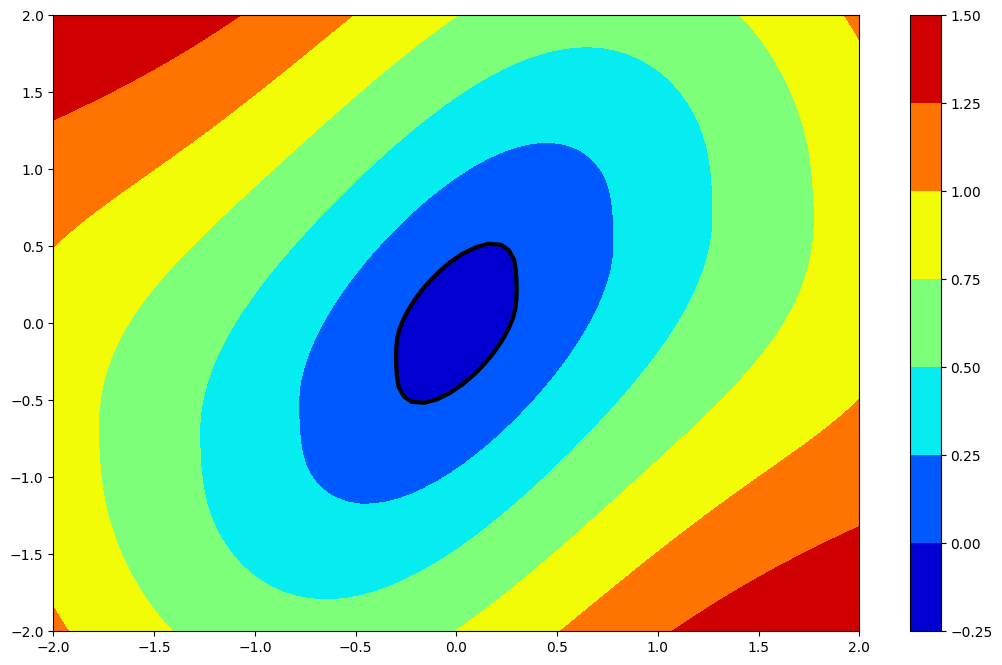

In [37]:
# print(target_values)
print(target_values.shape)

plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values.T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[: , :].T,
            levels=0,
            colors="black",
            linewidths=3)

In [40]:
times = np.linspace(-2.8, 0, 57) # *20 + 1
# values = initial_values
print(values.shape)
all_values = hj.solve(solver_settings, dynamics, grid, times, values)
print(all_values.shape)

(64, 64)


100%|##########|  2.8000/2.8 [00:00<00:00,  3.96sim_s/s]

(57, 64, 64)


In [41]:
vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), round(vmax) - round(vmin) + 1)
fig = plt.figure(figsize=(13, 8))


def render_frame(i, colorbar=False):
    plt.contourf(grid.coordinate_vectors[0],
                 grid.coordinate_vectors[1],
                 all_values[i, :, :].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    if colorbar:
        plt.colorbar()
    plt.contour(grid.coordinate_vectors[0],
                grid.coordinate_vectors[1],
                target_values.T,
                levels=0,
                colors="black",
                linewidths=3)
    


render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=50).to_html5_video())
plt.close(); animation